In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
import numpy as np
import cv2
import random

In [2]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 71 (delta 34), reused 31 (delta 9), pack-reused 0
Receiving objects: 100% (71/71), 125.53 KiB | 528.00 KiB/s, done.
Resolving deltas: 100% (34/34), done.


In [2]:
import torch
from torchvision import datasets, transforms
import random
import numpy as np

from data_complexity_measures.models.SeprationIndex import Kalhor_SeparationIndex

# CLAHE

In [4]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Create PyTorch data loaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, shuffle=False)

# Check the number of samples in each set
print(f"Combined Train set size: {len(cifar100_train_combined)}")
print(f"Combined Test set size: {len(cifar100_test_combined)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Combined Train set size: 100000
Combined Test set size: 10000


In [7]:
# Load EfficientNetV2-S model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# 100 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 100)
)

In [8]:
classifier = model.classifier
print(classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


In [9]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=4, gamma=0.2)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses = [], []
train_acc, val_acc = [], []

best_val_acc = 0.0
best_model_path = 'efficientnetv2_s_cifar100_best.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)


    scheduler.step()

    # Check if the current model has the best validation accuracy
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Save model weights
torch.save(model.state_dict(), 'efficientnetv2_s_cifar100_augmented_first_method.pth')

Epoch 1/20: 100%|█████████████████████████████| 391/391 [01:04<00:00,  6.09it/s]


Epoch 1/20 | Train Loss: 2.3408 | Train Acc: 40.15% | Val Loss: 1.5929 | Val Acc: 55.42%


Epoch 2/20: 100%|█████████████████████████████| 391/391 [01:01<00:00,  6.36it/s]


Epoch 2/20 | Train Loss: 1.1910 | Train Acc: 65.75% | Val Loss: 1.4926 | Val Acc: 59.83%


Epoch 3/20: 100%|█████████████████████████████| 391/391 [01:01<00:00,  6.34it/s]


Epoch 3/20 | Train Loss: 0.8116 | Train Acc: 75.72% | Val Loss: 1.4893 | Val Acc: 60.61%


Epoch 4/20: 100%|█████████████████████████████| 391/391 [01:01<00:00,  6.36it/s]


Epoch 4/20 | Train Loss: 0.5720 | Train Acc: 82.49% | Val Loss: 1.6559 | Val Acc: 60.40%


Epoch 5/20: 100%|█████████████████████████████| 391/391 [01:01<00:00,  6.40it/s]


Epoch 5/20 | Train Loss: 0.2078 | Train Acc: 93.70% | Val Loss: 1.5659 | Val Acc: 65.10%


Epoch 6/20: 100%|█████████████████████████████| 391/391 [01:01<00:00,  6.37it/s]


Epoch 6/20 | Train Loss: 0.0999 | Train Acc: 97.18% | Val Loss: 1.6538 | Val Acc: 64.89%


Epoch 7/20: 100%|█████████████████████████████| 391/391 [01:01<00:00,  6.41it/s]


Epoch 7/20 | Train Loss: 0.0643 | Train Acc: 98.28% | Val Loss: 1.7771 | Val Acc: 65.33%


Epoch 8/20: 100%|█████████████████████████████| 391/391 [01:01<00:00,  6.37it/s]


Epoch 8/20 | Train Loss: 0.0480 | Train Acc: 98.67% | Val Loss: 1.8506 | Val Acc: 65.27%


Epoch 9/20: 100%|█████████████████████████████| 391/391 [01:00<00:00,  6.41it/s]


Epoch 9/20 | Train Loss: 0.0338 | Train Acc: 99.13% | Val Loss: 1.8274 | Val Acc: 65.40%


Epoch 10/20: 100%|████████████████████████████| 391/391 [01:00<00:00,  6.41it/s]


Epoch 10/20 | Train Loss: 0.0254 | Train Acc: 99.38% | Val Loss: 1.8440 | Val Acc: 65.68%


Epoch 11/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.37it/s]


Epoch 11/20 | Train Loss: 0.0222 | Train Acc: 99.47% | Val Loss: 1.8740 | Val Acc: 65.74%


Epoch 12/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.35it/s]


Epoch 12/20 | Train Loss: 0.0184 | Train Acc: 99.56% | Val Loss: 1.8906 | Val Acc: 65.70%


Epoch 13/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.39it/s]


Epoch 13/20 | Train Loss: 0.0167 | Train Acc: 99.61% | Val Loss: 1.9021 | Val Acc: 65.92%


Epoch 14/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.37it/s]


Epoch 14/20 | Train Loss: 0.0158 | Train Acc: 99.62% | Val Loss: 1.9033 | Val Acc: 65.91%


Epoch 15/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.40it/s]


Epoch 15/20 | Train Loss: 0.0151 | Train Acc: 99.66% | Val Loss: 1.9068 | Val Acc: 65.87%


Epoch 16/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.39it/s]


Epoch 16/20 | Train Loss: 0.0153 | Train Acc: 99.62% | Val Loss: 1.9192 | Val Acc: 65.70%


Epoch 17/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.40it/s]


Epoch 17/20 | Train Loss: 0.0136 | Train Acc: 99.70% | Val Loss: 1.9178 | Val Acc: 65.79%


Epoch 18/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.39it/s]


Epoch 18/20 | Train Loss: 0.0137 | Train Acc: 99.69% | Val Loss: 1.9122 | Val Acc: 65.89%


Epoch 19/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.39it/s]


Epoch 19/20 | Train Loss: 0.0138 | Train Acc: 99.67% | Val Loss: 1.9210 | Val Acc: 66.05%


Epoch 20/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.38it/s]


Epoch 20/20 | Train Loss: 0.0134 | Train Acc: 99.70% | Val Loss: 1.9197 | Val Acc: 65.97%


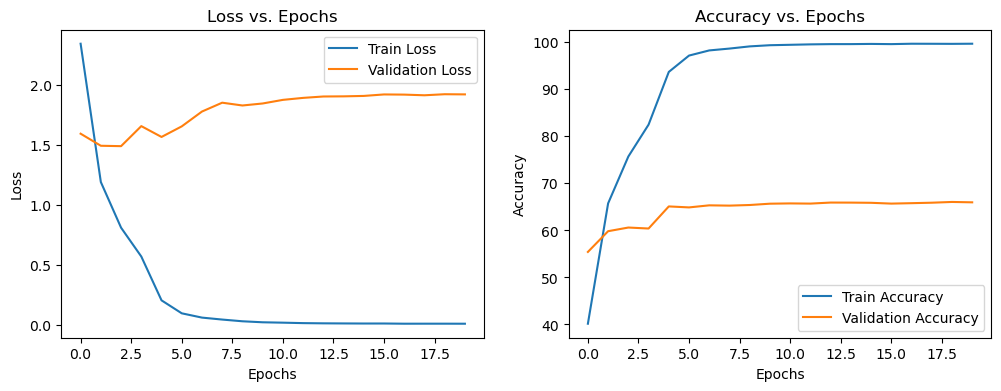

In [10]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

plt.show()

In [11]:
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


Final Test Accuracy: 66.05%


## SI cross for CLAHE

In [12]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Define the size of the balanced subset for both train and test sets
subset_fraction_train = 0.2
subset_fraction_test = 0.2

# Calculate the number of samples needed for the balanced subset for both train and test sets
subset_size_train = int(subset_fraction_train * len(cifar100_train_combined))
subset_size_test = int(subset_fraction_test * len(cifar100_test_combined))

# Create a balanced subset for both train and test sets using SubsetRandomSampler
class_indices_train = list(range(len(cifar100_train_augmented.classes)))
class_indices_test = list(range(len(cifar100_test_augmented.classes)))

class_subset_size_train = int(subset_size_train / len(cifar100_train_augmented.classes))
class_subset_size_test = int(subset_size_test / len(cifar100_test_augmented.classes))

class_sampler_indices_train = []
class_sampler_indices_test = []

for class_index in class_indices_train:
    class_indices_list_train = [i for i, label in enumerate(cifar100_train_augmented.targets) if label == class_index]
    class_sampler_indices_train.extend(class_indices_list_train[:class_subset_size_train])

for class_index in class_indices_test:
    class_indices_list_test = [i for i, label in enumerate(cifar100_test_augmented.targets) if label == class_index]
    class_sampler_indices_test.extend(class_indices_list_test[:class_subset_size_test])

train_sampler = SubsetRandomSampler(class_sampler_indices_train)
test_sampler = SubsetRandomSampler(class_sampler_indices_test)

# Create PyTorch data loaders using the balanced subset for both train and test sets
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, sampler=test_sampler)

# Check the number of samples in each set
print(f"Balanced Train set size: {len(train_loader.sampler)}")
print(f"Balanced Test set size: {len(test_loader.sampler)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Balanced Train set size: 20000
Balanced Test set size: 2000


In [13]:
# Extract data and labels from loaders
cifar100_train_data, cifar100_train_labels = [], []
for data, label in train_loader:
    cifar100_train_data.append(data)
    cifar100_train_labels.append(label)

cifar100_test_data, cifar100_test_labels = [], []
for data, label in test_loader:
    cifar100_test_data.append(data)
    cifar100_test_labels.append(label)

# Concatenate the lists of tensors
cifar100_train_data = torch.cat(cifar100_train_data, dim=0)
cifar100_train_labels = torch.cat(cifar100_train_labels, dim=0)
cifar100_test_data = torch.cat(cifar100_test_data, dim=0)
cifar100_test_labels = torch.cat(cifar100_test_labels, dim=0)

# Convert to desired format
train_data_tensor = cifar100_train_data
train_data_tensor = train_data_tensor.view(train_data_tensor.size(0), -1)

train_label_tensor = cifar100_train_labels.unsqueeze(1)

test_data_tensor = cifar100_test_data
test_data_tensor = test_data_tensor.view(test_data_tensor.size(0), -1)

test_label_tensor = cifar100_test_labels.unsqueeze(1)

In [14]:
train_si_calculator = Kalhor_SeparationIndex(train_data_tensor, train_label_tensor, normalize=True)
test_si_calculator = Kalhor_SeparationIndex(test_data_tensor, test_label_tensor, normalize=True)

data becomes normalized
data becomes normalized


In [15]:
# Calculate cross_si_data for the test dataset
cross_si_data = train_si_calculator.cross_si_data(test_data_tensor, test_label_tensor)
num_ones = torch.sum(cross_si_data == True).item()
total_elements = cross_si_data.numel()
ratio_ones = num_ones / total_elements

print("Cross SI:", ratio_ones)

Cross SI: 0.144


# AdvancedBlur

In [3]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.AdvancedBlur(blur_limit=(3, 7), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1), always_apply=False, p=0.5),
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Create PyTorch data loaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, shuffle=False)

# Check the number of samples in each set
print(f"Combined Train set size: {len(cifar100_train_combined)}")
print(f"Combined Test set size: {len(cifar100_test_combined)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Combined Train set size: 100000
Combined Test set size: 10000


In [4]:
# Load EfficientNetV2-S model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# 100 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 100)
)

In [5]:
classifier = model.classifier
print(classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


In [6]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=4, gamma=0.2)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses = [], []
train_acc, val_acc = [], []

best_val_acc = 0.0
best_model_path = 'efficientnetv2_s_cifar100_best.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)


    scheduler.step()

    # Check if the current model has the best validation accuracy
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Save model weights
torch.save(model.state_dict(), 'efficientnetv2_s_cifar100_augmented_second_method.pth')

Epoch 1/20: 100%|█████████████████████████████| 391/391 [01:10<00:00,  5.57it/s]


Epoch 1/20 | Train Loss: 2.2742 | Train Acc: 41.68% | Val Loss: 1.6803 | Val Acc: 54.87%


Epoch 2/20: 100%|█████████████████████████████| 391/391 [01:07<00:00,  5.75it/s]


Epoch 2/20 | Train Loss: 1.2405 | Train Acc: 64.62% | Val Loss: 1.5360 | Val Acc: 59.28%


Epoch 3/20: 100%|█████████████████████████████| 391/391 [01:07<00:00,  5.80it/s]


Epoch 3/20 | Train Loss: 0.8320 | Train Acc: 75.51% | Val Loss: 1.6708 | Val Acc: 58.10%


Epoch 4/20: 100%|█████████████████████████████| 391/391 [01:07<00:00,  5.80it/s]


Epoch 4/20 | Train Loss: 0.5981 | Train Acc: 81.80% | Val Loss: 1.7333 | Val Acc: 59.65%


Epoch 5/20: 100%|█████████████████████████████| 391/391 [01:11<00:00,  5.50it/s]


Epoch 5/20 | Train Loss: 0.2155 | Train Acc: 93.66% | Val Loss: 1.6453 | Val Acc: 64.49%


Epoch 6/20: 100%|█████████████████████████████| 391/391 [02:58<00:00,  2.19it/s]


Epoch 6/20 | Train Loss: 0.0997 | Train Acc: 97.28% | Val Loss: 1.6803 | Val Acc: 64.72%


Epoch 7/20: 100%|█████████████████████████████| 391/391 [03:21<00:00,  1.94it/s]


Epoch 7/20 | Train Loss: 0.0689 | Train Acc: 98.12% | Val Loss: 1.8239 | Val Acc: 64.65%


Epoch 8/20: 100%|█████████████████████████████| 391/391 [03:19<00:00,  1.96it/s]


Epoch 8/20 | Train Loss: 0.0562 | Train Acc: 98.49% | Val Loss: 1.8691 | Val Acc: 64.53%


Epoch 9/20: 100%|█████████████████████████████| 391/391 [02:08<00:00,  3.03it/s]


Epoch 9/20 | Train Loss: 0.0396 | Train Acc: 99.00% | Val Loss: 1.8784 | Val Acc: 65.23%


Epoch 10/20: 100%|████████████████████████████| 391/391 [01:06<00:00,  5.85it/s]


Epoch 10/20 | Train Loss: 0.0324 | Train Acc: 99.17% | Val Loss: 1.8672 | Val Acc: 65.62%


Epoch 11/20: 100%|████████████████████████████| 391/391 [01:06<00:00,  5.85it/s]


Epoch 11/20 | Train Loss: 0.0275 | Train Acc: 99.31% | Val Loss: 1.9476 | Val Acc: 65.25%


Epoch 12/20: 100%|████████████████████████████| 391/391 [01:07<00:00,  5.81it/s]


Epoch 12/20 | Train Loss: 0.0261 | Train Acc: 99.32% | Val Loss: 1.9380 | Val Acc: 65.69%


Epoch 13/20: 100%|████████████████████████████| 391/391 [01:06<00:00,  5.84it/s]


Epoch 13/20 | Train Loss: 0.0229 | Train Acc: 99.43% | Val Loss: 1.9536 | Val Acc: 65.53%


Epoch 14/20: 100%|████████████████████████████| 391/391 [01:07<00:00,  5.78it/s]


Epoch 14/20 | Train Loss: 0.0231 | Train Acc: 99.41% | Val Loss: 1.9031 | Val Acc: 65.73%


Epoch 15/20: 100%|████████████████████████████| 391/391 [01:06<00:00,  5.85it/s]


Epoch 15/20 | Train Loss: 0.0224 | Train Acc: 99.40% | Val Loss: 1.9144 | Val Acc: 65.54%


Epoch 16/20: 100%|████████████████████████████| 391/391 [01:06<00:00,  5.85it/s]


Epoch 16/20 | Train Loss: 0.0208 | Train Acc: 99.45% | Val Loss: 1.9443 | Val Acc: 65.59%


Epoch 17/20: 100%|████████████████████████████| 391/391 [01:07<00:00,  5.82it/s]


Epoch 17/20 | Train Loss: 0.0204 | Train Acc: 99.47% | Val Loss: 1.9019 | Val Acc: 65.72%


Epoch 18/20: 100%|████████████████████████████| 391/391 [01:07<00:00,  5.79it/s]


Epoch 18/20 | Train Loss: 0.0192 | Train Acc: 99.52% | Val Loss: 1.8854 | Val Acc: 65.55%


Epoch 19/20: 100%|████████████████████████████| 391/391 [01:06<00:00,  5.86it/s]


Epoch 19/20 | Train Loss: 0.0201 | Train Acc: 99.47% | Val Loss: 1.9433 | Val Acc: 65.72%


Epoch 20/20: 100%|████████████████████████████| 391/391 [01:07<00:00,  5.75it/s]


Epoch 20/20 | Train Loss: 0.0193 | Train Acc: 99.52% | Val Loss: 1.9140 | Val Acc: 65.49%


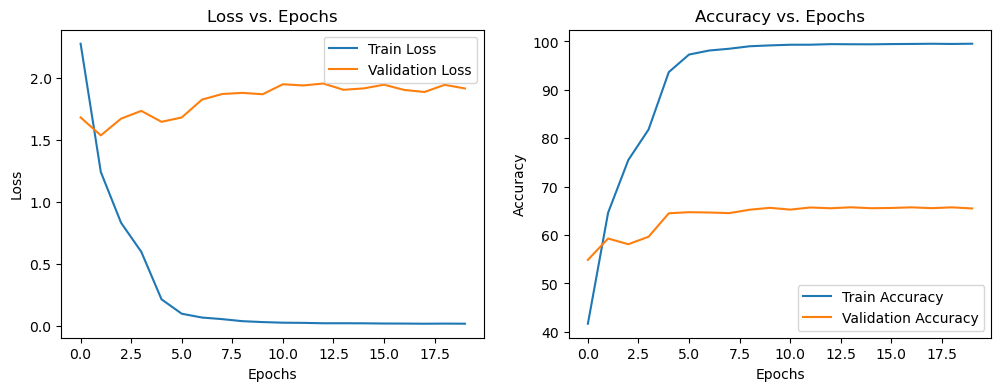

In [7]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

plt.show()

In [8]:
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


Final Test Accuracy: 65.73%


## SI cross for AdvancedBlur

In [21]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.AdvancedBlur(blur_limit=(3, 7), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1), always_apply=False, p=0.5),
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Define the size of the balanced subset for both train and test sets
subset_fraction_train = 0.2
subset_fraction_test = 0.2

# Calculate the number of samples needed for the balanced subset for both train and test sets
subset_size_train = int(subset_fraction_train * len(cifar100_train_combined))
subset_size_test = int(subset_fraction_test * len(cifar100_test_combined))

# Create a balanced subset for both train and test sets using SubsetRandomSampler
class_indices_train = list(range(len(cifar100_train_augmented.classes)))
class_indices_test = list(range(len(cifar100_test_augmented.classes)))

class_subset_size_train = int(subset_size_train / len(cifar100_train_augmented.classes))
class_subset_size_test = int(subset_size_test / len(cifar100_test_augmented.classes))

class_sampler_indices_train = []
class_sampler_indices_test = []

for class_index in class_indices_train:
    class_indices_list_train = [i for i, label in enumerate(cifar100_train_augmented.targets) if label == class_index]
    class_sampler_indices_train.extend(class_indices_list_train[:class_subset_size_train])

for class_index in class_indices_test:
    class_indices_list_test = [i for i, label in enumerate(cifar100_test_augmented.targets) if label == class_index]
    class_sampler_indices_test.extend(class_indices_list_test[:class_subset_size_test])

train_sampler = SubsetRandomSampler(class_sampler_indices_train)
test_sampler = SubsetRandomSampler(class_sampler_indices_test)

# Create PyTorch data loaders using the balanced subset for both train and test sets
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, sampler=test_sampler)

# Check the number of samples in each set
print(f"Balanced Train set size: {len(train_loader.sampler)}")
print(f"Balanced Test set size: {len(test_loader.sampler)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Balanced Train set size: 20000
Balanced Test set size: 2000


In [22]:
# Extract data and labels from loaders
cifar100_train_data, cifar100_train_labels = [], []
for data, label in train_loader:
    cifar100_train_data.append(data)
    cifar100_train_labels.append(label)

cifar100_test_data, cifar100_test_labels = [], []
for data, label in test_loader:
    cifar100_test_data.append(data)
    cifar100_test_labels.append(label)

# Concatenate the lists of tensors
cifar100_train_data = torch.cat(cifar100_train_data, dim=0)
cifar100_train_labels = torch.cat(cifar100_train_labels, dim=0)
cifar100_test_data = torch.cat(cifar100_test_data, dim=0)
cifar100_test_labels = torch.cat(cifar100_test_labels, dim=0)

# Convert to desired format
train_data_tensor = cifar100_train_data
train_data_tensor = train_data_tensor.view(train_data_tensor.size(0), -1)

train_label_tensor = cifar100_train_labels.unsqueeze(1)

test_data_tensor = cifar100_test_data
test_data_tensor = test_data_tensor.view(test_data_tensor.size(0), -1)

test_label_tensor = cifar100_test_labels.unsqueeze(1)

In [23]:
train_si_calculator = Kalhor_SeparationIndex(train_data_tensor, train_label_tensor, normalize=True)
test_si_calculator = Kalhor_SeparationIndex(test_data_tensor, test_label_tensor, normalize=True)

data becomes normalized
data becomes normalized


In [24]:
# Calculate cross_si_data for the test dataset
cross_si_data = train_si_calculator.cross_si_data(test_data_tensor, test_label_tensor)
num_ones = torch.sum(cross_si_data == True).item()
total_elements = cross_si_data.numel()
ratio_ones = num_ones / total_elements

print("Cross SI:", ratio_ones)

Cross SI: 0.144


# GaussNoise

In [9]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.GaussNoise (var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.5)
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Create PyTorch data loaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, shuffle=False)

# Check the number of samples in each set
print(f"Combined Train set size: {len(cifar100_train_combined)}")
print(f"Combined Test set size: {len(cifar100_test_combined)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Combined Train set size: 100000
Combined Test set size: 10000


In [10]:
# Load EfficientNetV2-S model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# 100 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 100)
)

In [11]:
classifier = model.classifier
print(classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


In [12]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=4, gamma=0.2)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses = [], []
train_acc, val_acc = [], []

best_val_acc = 0.0
best_model_path = 'efficientnetv2_s_cifar100_best.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)


    scheduler.step()

    # Check if the current model has the best validation accuracy
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Save model weights
torch.save(model.state_dict(), 'efficientnetv2_s_cifar100_augmented_third_method.pth')

Epoch 1/20: 100%|█████████████████████████████| 391/391 [01:05<00:00,  5.93it/s]


Epoch 1/20 | Train Loss: 2.2670 | Train Acc: 41.69% | Val Loss: 1.6702 | Val Acc: 54.26%


Epoch 2/20: 100%|█████████████████████████████| 391/391 [01:06<00:00,  5.90it/s]


Epoch 2/20 | Train Loss: 1.1558 | Train Acc: 66.54% | Val Loss: 1.5713 | Val Acc: 58.43%


Epoch 3/20: 100%|█████████████████████████████| 391/391 [01:05<00:00,  5.93it/s]


Epoch 3/20 | Train Loss: 0.7531 | Train Acc: 77.18% | Val Loss: 1.5800 | Val Acc: 60.65%


Epoch 4/20: 100%|█████████████████████████████| 391/391 [01:06<00:00,  5.88it/s]


Epoch 4/20 | Train Loss: 0.5210 | Train Acc: 83.91% | Val Loss: 1.6767 | Val Acc: 60.78%


Epoch 5/20: 100%|█████████████████████████████| 391/391 [01:05<00:00,  5.93it/s]


Epoch 5/20 | Train Loss: 0.1687 | Train Acc: 94.92% | Val Loss: 1.6279 | Val Acc: 64.76%


Epoch 6/20: 100%|█████████████████████████████| 391/391 [01:05<00:00,  5.94it/s]


Epoch 6/20 | Train Loss: 0.0820 | Train Acc: 97.76% | Val Loss: 1.7522 | Val Acc: 64.91%


Epoch 7/20: 100%|█████████████████████████████| 391/391 [01:05<00:00,  5.97it/s]


Epoch 7/20 | Train Loss: 0.0504 | Train Acc: 98.68% | Val Loss: 1.8327 | Val Acc: 65.27%


Epoch 8/20: 100%|█████████████████████████████| 391/391 [01:05<00:00,  5.96it/s]


Epoch 8/20 | Train Loss: 0.0361 | Train Acc: 99.06% | Val Loss: 1.9246 | Val Acc: 64.99%


Epoch 9/20: 100%|█████████████████████████████| 391/391 [01:05<00:00,  5.97it/s]


Epoch 9/20 | Train Loss: 0.0251 | Train Acc: 99.38% | Val Loss: 1.9075 | Val Acc: 65.43%


Epoch 10/20: 100%|████████████████████████████| 391/391 [01:05<00:00,  5.95it/s]


Epoch 10/20 | Train Loss: 0.0191 | Train Acc: 99.52% | Val Loss: 1.9361 | Val Acc: 65.29%


Epoch 11/20: 100%|████████████████████████████| 391/391 [01:05<00:00,  5.95it/s]


Epoch 11/20 | Train Loss: 0.0177 | Train Acc: 99.59% | Val Loss: 1.9552 | Val Acc: 65.66%


Epoch 12/20: 100%|████████████████████████████| 391/391 [01:05<00:00,  5.96it/s]


Epoch 12/20 | Train Loss: 0.0150 | Train Acc: 99.64% | Val Loss: 1.9938 | Val Acc: 65.63%


Epoch 13/20: 100%|████████████████████████████| 391/391 [01:05<00:00,  5.93it/s]


Epoch 13/20 | Train Loss: 0.0137 | Train Acc: 99.66% | Val Loss: 1.9808 | Val Acc: 65.78%


Epoch 14/20: 100%|████████████████████████████| 391/391 [01:05<00:00,  5.94it/s]


Epoch 14/20 | Train Loss: 0.0130 | Train Acc: 99.71% | Val Loss: 1.9899 | Val Acc: 65.69%


Epoch 15/20: 100%|████████████████████████████| 391/391 [01:05<00:00,  5.99it/s]


Epoch 15/20 | Train Loss: 0.0130 | Train Acc: 99.70% | Val Loss: 1.9796 | Val Acc: 65.86%


Epoch 16/20: 100%|████████████████████████████| 391/391 [01:05<00:00,  5.94it/s]


Epoch 16/20 | Train Loss: 0.0117 | Train Acc: 99.72% | Val Loss: 1.9892 | Val Acc: 65.83%


Epoch 17/20: 100%|████████████████████████████| 391/391 [01:05<00:00,  5.97it/s]


Epoch 17/20 | Train Loss: 0.0122 | Train Acc: 99.71% | Val Loss: 1.9920 | Val Acc: 65.83%


Epoch 18/20: 100%|████████████████████████████| 391/391 [01:05<00:00,  5.98it/s]


Epoch 18/20 | Train Loss: 0.0115 | Train Acc: 99.72% | Val Loss: 2.0081 | Val Acc: 65.72%


Epoch 19/20: 100%|████████████████████████████| 391/391 [01:05<00:00,  5.95it/s]


Epoch 19/20 | Train Loss: 0.0115 | Train Acc: 99.73% | Val Loss: 1.9930 | Val Acc: 65.83%


Epoch 20/20: 100%|████████████████████████████| 391/391 [01:06<00:00,  5.86it/s]


Epoch 20/20 | Train Loss: 0.0108 | Train Acc: 99.77% | Val Loss: 1.9908 | Val Acc: 65.92%


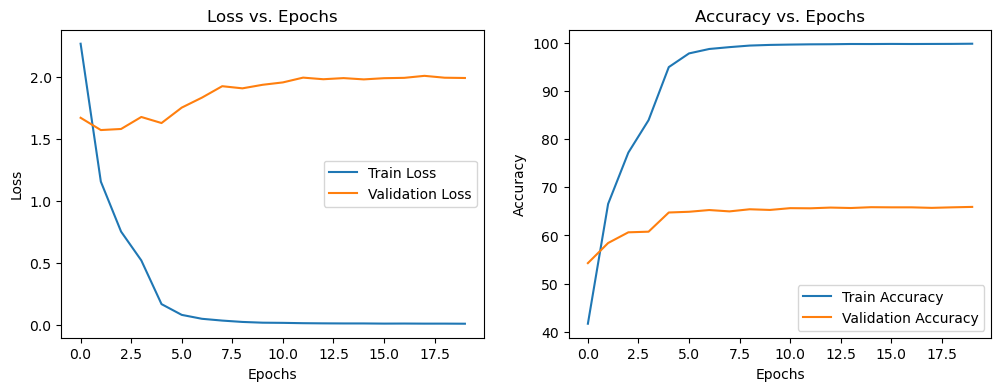

In [13]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

plt.show()

In [14]:
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Final Test Accuracy: 65.92%


## SI cross for GaussNoise

In [30]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.GaussNoise (var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.5)
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Define the size of the balanced subset for both train and test sets
subset_fraction_train = 0.2
subset_fraction_test = 0.2

# Calculate the number of samples needed for the balanced subset for both train and test sets
subset_size_train = int(subset_fraction_train * len(cifar100_train_combined))
subset_size_test = int(subset_fraction_test * len(cifar100_test_combined))

# Create a balanced subset for both train and test sets using SubsetRandomSampler
class_indices_train = list(range(len(cifar100_train_augmented.classes)))
class_indices_test = list(range(len(cifar100_test_augmented.classes)))

class_subset_size_train = int(subset_size_train / len(cifar100_train_augmented.classes))
class_subset_size_test = int(subset_size_test / len(cifar100_test_augmented.classes))

class_sampler_indices_train = []
class_sampler_indices_test = []

for class_index in class_indices_train:
    class_indices_list_train = [i for i, label in enumerate(cifar100_train_augmented.targets) if label == class_index]
    class_sampler_indices_train.extend(class_indices_list_train[:class_subset_size_train])

for class_index in class_indices_test:
    class_indices_list_test = [i for i, label in enumerate(cifar100_test_augmented.targets) if label == class_index]
    class_sampler_indices_test.extend(class_indices_list_test[:class_subset_size_test])

train_sampler = SubsetRandomSampler(class_sampler_indices_train)
test_sampler = SubsetRandomSampler(class_sampler_indices_test)

# Create PyTorch data loaders using the balanced subset for both train and test sets
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, sampler=test_sampler)

# Check the number of samples in each set
print(f"Balanced Train set size: {len(train_loader.sampler)}")
print(f"Balanced Test set size: {len(test_loader.sampler)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Balanced Train set size: 20000
Balanced Test set size: 2000


In [31]:
# Extract data and labels from loaders
cifar100_train_data, cifar100_train_labels = [], []
for data, label in train_loader:
    cifar100_train_data.append(data)
    cifar100_train_labels.append(label)

cifar100_test_data, cifar100_test_labels = [], []
for data, label in test_loader:
    cifar100_test_data.append(data)
    cifar100_test_labels.append(label)

# Concatenate the lists of tensors
cifar100_train_data = torch.cat(cifar100_train_data, dim=0)
cifar100_train_labels = torch.cat(cifar100_train_labels, dim=0)
cifar100_test_data = torch.cat(cifar100_test_data, dim=0)
cifar100_test_labels = torch.cat(cifar100_test_labels, dim=0)

# Convert to desired format
train_data_tensor = cifar100_train_data
train_data_tensor = train_data_tensor.view(train_data_tensor.size(0), -1)

train_label_tensor = cifar100_train_labels.unsqueeze(1)

test_data_tensor = cifar100_test_data
test_data_tensor = test_data_tensor.view(test_data_tensor.size(0), -1)

test_label_tensor = cifar100_test_labels.unsqueeze(1)

In [32]:
train_si_calculator = Kalhor_SeparationIndex(train_data_tensor, train_label_tensor, normalize=True)
test_si_calculator = Kalhor_SeparationIndex(test_data_tensor, test_label_tensor, normalize=True)

data becomes normalized
data becomes normalized


In [33]:
# Calculate cross_si_data for the test dataset
cross_si_data = train_si_calculator.cross_si_data(test_data_tensor, test_label_tensor)
num_ones = torch.sum(cross_si_data == True).item()
total_elements = cross_si_data.numel()
ratio_ones = num_ones / total_elements

print("Cross SI:", ratio_ones)

Cross SI: 0.144


# RandomRain

In [15]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.RandomRain(slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(200, 200, 200), blur_value=7, brightness_coefficient=0.7, rain_type=None, always_apply=False, p=0.5)
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Create PyTorch data loaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, shuffle=False)

# Check the number of samples in each set
print(f"Combined Train set size: {len(cifar100_train_combined)}")
print(f"Combined Test set size: {len(cifar100_test_combined)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Combined Train set size: 100000
Combined Test set size: 10000


In [16]:
# Load EfficientNetV2-S model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# 100 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 100)
)

In [17]:
classifier = model.classifier
print(classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


In [18]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=4, gamma=0.2)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses = [], []
train_acc, val_acc = [], []

best_val_acc = 0.0
best_model_path = 'efficientnetv2_s_cifar100_best.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)


    scheduler.step()

    # Check if the current model has the best validation accuracy
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Save model weights
torch.save(model.state_dict(), 'efficientnetv2_s_cifar100_augmented_fourth_method.pth')

Epoch 1/20: 100%|█████████████████████████████| 391/391 [01:02<00:00,  6.26it/s]


Epoch 1/20 | Train Loss: 2.4562 | Train Acc: 37.68% | Val Loss: 1.5804 | Val Acc: 55.40%


Epoch 2/20: 100%|█████████████████████████████| 391/391 [01:02<00:00,  6.23it/s]


Epoch 2/20 | Train Loss: 1.3770 | Train Acc: 61.21% | Val Loss: 1.4942 | Val Acc: 59.87%


Epoch 3/20: 100%|█████████████████████████████| 391/391 [01:02<00:00,  6.29it/s]


Epoch 3/20 | Train Loss: 1.0145 | Train Acc: 70.64% | Val Loss: 1.4592 | Val Acc: 61.50%


Epoch 4/20: 100%|█████████████████████████████| 391/391 [01:02<00:00,  6.25it/s]


Epoch 4/20 | Train Loss: 0.8026 | Train Acc: 76.40% | Val Loss: 1.6276 | Val Acc: 60.71%


Epoch 5/20: 100%|█████████████████████████████| 391/391 [01:02<00:00,  6.29it/s]


Epoch 5/20 | Train Loss: 0.4227 | Train Acc: 87.59% | Val Loss: 1.5055 | Val Acc: 65.61%


Epoch 6/20: 100%|█████████████████████████████| 391/391 [01:02<00:00,  6.27it/s]


Epoch 6/20 | Train Loss: 0.2793 | Train Acc: 91.94% | Val Loss: 1.5970 | Val Acc: 65.71%


Epoch 7/20: 100%|█████████████████████████████| 391/391 [01:02<00:00,  6.29it/s]


Epoch 7/20 | Train Loss: 0.2237 | Train Acc: 93.56% | Val Loss: 1.6814 | Val Acc: 65.65%


Epoch 8/20: 100%|█████████████████████████████| 391/391 [01:02<00:00,  6.23it/s]


Epoch 8/20 | Train Loss: 0.1899 | Train Acc: 94.58% | Val Loss: 1.7353 | Val Acc: 65.02%


Epoch 9/20: 100%|█████████████████████████████| 391/391 [01:02<00:00,  6.21it/s]


Epoch 9/20 | Train Loss: 0.1339 | Train Acc: 96.17% | Val Loss: 1.7370 | Val Acc: 65.87%


Epoch 10/20: 100%|████████████████████████████| 391/391 [01:02<00:00,  6.28it/s]


Epoch 10/20 | Train Loss: 0.1126 | Train Acc: 96.82% | Val Loss: 1.7540 | Val Acc: 65.60%


Epoch 11/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.35it/s]


Epoch 11/20 | Train Loss: 0.1024 | Train Acc: 97.11% | Val Loss: 1.7966 | Val Acc: 65.73%


Epoch 12/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.37it/s]


Epoch 12/20 | Train Loss: 0.0934 | Train Acc: 97.29% | Val Loss: 1.8108 | Val Acc: 65.65%


Epoch 13/20: 100%|████████████████████████████| 391/391 [01:02<00:00,  6.29it/s]


Epoch 13/20 | Train Loss: 0.0824 | Train Acc: 97.63% | Val Loss: 1.8128 | Val Acc: 65.70%


Epoch 14/20: 100%|████████████████████████████| 391/391 [01:02<00:00,  6.25it/s]


Epoch 14/20 | Train Loss: 0.0796 | Train Acc: 97.76% | Val Loss: 1.8289 | Val Acc: 65.58%


Epoch 15/20: 100%|████████████████████████████| 391/391 [01:02<00:00,  6.30it/s]


Epoch 15/20 | Train Loss: 0.0764 | Train Acc: 97.86% | Val Loss: 1.8379 | Val Acc: 65.57%


Epoch 16/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.31it/s]


Epoch 16/20 | Train Loss: 0.0739 | Train Acc: 97.88% | Val Loss: 1.8450 | Val Acc: 65.42%


Epoch 17/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.32it/s]


Epoch 17/20 | Train Loss: 0.0735 | Train Acc: 97.92% | Val Loss: 1.8390 | Val Acc: 65.63%


Epoch 18/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.34it/s]


Epoch 18/20 | Train Loss: 0.0710 | Train Acc: 97.97% | Val Loss: 1.8471 | Val Acc: 65.61%


Epoch 19/20: 100%|████████████████████████████| 391/391 [01:02<00:00,  6.30it/s]


Epoch 19/20 | Train Loss: 0.0694 | Train Acc: 98.02% | Val Loss: 1.8496 | Val Acc: 65.45%


Epoch 20/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.31it/s]


Epoch 20/20 | Train Loss: 0.0700 | Train Acc: 98.01% | Val Loss: 1.8528 | Val Acc: 65.53%


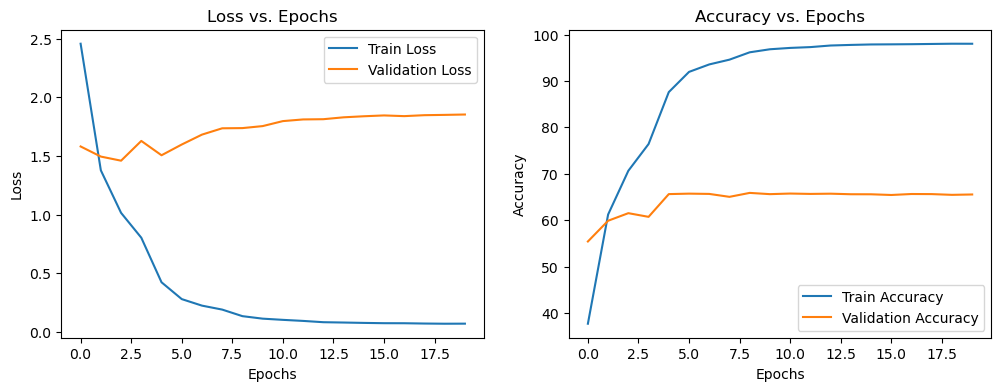

In [19]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

plt.show()

In [20]:
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Final Test Accuracy: 65.87%


## SI cross for RandomRain

In [ ]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
    A.RandomRain(slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(200, 200, 200), blur_value=7, brightness_coefficient=0.7, rain_type=None, always_apply=False, p=0.5)
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Define the size of the balanced subset for both train and test sets
subset_fraction_train = 0.2
subset_fraction_test = 0.2

# Calculate the number of samples needed for the balanced subset for both train and test sets
subset_size_train = int(subset_fraction_train * len(cifar100_train_combined))
subset_size_test = int(subset_fraction_test * len(cifar100_test_combined))

# Create a balanced subset for both train and test sets using SubsetRandomSampler
class_indices_train = list(range(len(cifar100_train_augmented.classes)))
class_indices_test = list(range(len(cifar100_test_augmented.classes)))

class_subset_size_train = int(subset_size_train / len(cifar100_train_augmented.classes))
class_subset_size_test = int(subset_size_test / len(cifar100_test_augmented.classes))

class_sampler_indices_train = []
class_sampler_indices_test = []

for class_index in class_indices_train:
    class_indices_list_train = [i for i, label in enumerate(cifar100_train_augmented.targets) if label == class_index]
    class_sampler_indices_train.extend(class_indices_list_train[:class_subset_size_train])

for class_index in class_indices_test:
    class_indices_list_test = [i for i, label in enumerate(cifar100_test_augmented.targets) if label == class_index]
    class_sampler_indices_test.extend(class_indices_list_test[:class_subset_size_test])

train_sampler = SubsetRandomSampler(class_sampler_indices_train)
test_sampler = SubsetRandomSampler(class_sampler_indices_test)

# Create PyTorch data loaders using the balanced subset for both train and test sets
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, sampler=test_sampler)

# Check the number of samples in each set
print(f"Balanced Train set size: {len(train_loader.sampler)}")
print(f"Balanced Test set size: {len(test_loader.sampler)}")


In [ ]:
# Extract data and labels from loaders
cifar100_train_data, cifar100_train_labels = [], []
for data, label in train_loader:
    cifar100_train_data.append(data)
    cifar100_train_labels.append(label)

cifar100_test_data, cifar100_test_labels = [], []
for data, label in test_loader:
    cifar100_test_data.append(data)
    cifar100_test_labels.append(label)

# Concatenate the lists of tensors
cifar100_train_data = torch.cat(cifar100_train_data, dim=0)
cifar100_train_labels = torch.cat(cifar100_train_labels, dim=0)
cifar100_test_data = torch.cat(cifar100_test_data, dim=0)
cifar100_test_labels = torch.cat(cifar100_test_labels, dim=0)

# Convert to desired format
train_data_tensor = cifar100_train_data
train_data_tensor = train_data_tensor.view(train_data_tensor.size(0), -1)

train_label_tensor = cifar100_train_labels.unsqueeze(1)

test_data_tensor = cifar100_test_data
test_data_tensor = test_data_tensor.view(test_data_tensor.size(0), -1)

test_label_tensor = cifar100_test_labels.unsqueeze(1)

In [ ]:
train_si_calculator = Kalhor_SeparationIndex(train_data_tensor, train_label_tensor, normalize=True)
test_si_calculator = Kalhor_SeparationIndex(test_data_tensor, test_label_tensor, normalize=True)

In [ ]:
# Calculate cross_si_data for the test dataset
cross_si_data = train_si_calculator.cross_si_data(test_data_tensor, test_label_tensor)
num_ones = torch.sum(cross_si_data == True).item()
total_elements = cross_si_data.numel()
ratio_ones = num_ones / total_elements

print("Cross SI:", ratio_ones)

# ToGray

In [21]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
     A.ToGray()
     ])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Create PyTorch data loaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, shuffle=False)

# Check the number of samples in each set
print(f"Combined Train set size: {len(cifar100_train_combined)}")
print(f"Combined Test set size: {len(cifar100_test_combined)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Combined Train set size: 100000
Combined Test set size: 10000


In [22]:
# Load EfficientNetV2-S model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# 100 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 100)
)

In [23]:
classifier = model.classifier
print(classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


In [24]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=4, gamma=0.2)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses = [], []
train_acc, val_acc = [], []

best_val_acc = 0.0
best_model_path = 'efficientnetv2_s_cifar100_best.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)


    scheduler.step()

    # Check if the current model has the best validation accuracy
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Save model weights
torch.save(model.state_dict(), 'efficientnetv2_s_cifar100_augmented_fifth_method.pth')

Epoch 1/20: 100%|█████████████████████████████| 391/391 [01:00<00:00,  6.43it/s]


Epoch 1/20 | Train Loss: 2.3311 | Train Acc: 40.27% | Val Loss: 1.5746 | Val Acc: 56.40%


Epoch 2/20: 100%|█████████████████████████████| 391/391 [01:00<00:00,  6.44it/s]


Epoch 2/20 | Train Loss: 1.2230 | Train Acc: 65.04% | Val Loss: 1.5003 | Val Acc: 59.50%


Epoch 3/20: 100%|█████████████████████████████| 391/391 [01:00<00:00,  6.43it/s]


Epoch 3/20 | Train Loss: 0.8429 | Train Acc: 75.17% | Val Loss: 1.5743 | Val Acc: 60.54%


Epoch 4/20: 100%|█████████████████████████████| 391/391 [01:00<00:00,  6.41it/s]


Epoch 4/20 | Train Loss: 0.6349 | Train Acc: 80.96% | Val Loss: 1.6227 | Val Acc: 60.55%


Epoch 5/20: 100%|█████████████████████████████| 391/391 [01:00<00:00,  6.44it/s]


Epoch 5/20 | Train Loss: 0.2448 | Train Acc: 92.58% | Val Loss: 1.5622 | Val Acc: 65.18%


Epoch 6/20: 100%|█████████████████████████████| 391/391 [01:00<00:00,  6.44it/s]


Epoch 6/20 | Train Loss: 0.1218 | Train Acc: 96.53% | Val Loss: 1.6749 | Val Acc: 65.74%


Epoch 7/20: 100%|█████████████████████████████| 391/391 [01:00<00:00,  6.41it/s]


Epoch 7/20 | Train Loss: 0.0819 | Train Acc: 97.71% | Val Loss: 1.7690 | Val Acc: 64.80%


Epoch 8/20: 100%|█████████████████████████████| 391/391 [01:01<00:00,  6.41it/s]


Epoch 8/20 | Train Loss: 0.0610 | Train Acc: 98.32% | Val Loss: 1.8499 | Val Acc: 64.94%


Epoch 9/20: 100%|█████████████████████████████| 391/391 [01:01<00:00,  6.39it/s]


Epoch 9/20 | Train Loss: 0.0422 | Train Acc: 98.90% | Val Loss: 1.8586 | Val Acc: 65.21%


Epoch 10/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.40it/s]


Epoch 10/20 | Train Loss: 0.0333 | Train Acc: 99.14% | Val Loss: 1.8779 | Val Acc: 65.29%


Epoch 11/20: 100%|████████████████████████████| 391/391 [01:00<00:00,  6.43it/s]


Epoch 11/20 | Train Loss: 0.0271 | Train Acc: 99.32% | Val Loss: 1.8925 | Val Acc: 65.38%


Epoch 12/20: 100%|████████████████████████████| 391/391 [01:00<00:00,  6.43it/s]


Epoch 12/20 | Train Loss: 0.0247 | Train Acc: 99.40% | Val Loss: 1.9274 | Val Acc: 65.45%


Epoch 13/20: 100%|████████████████████████████| 391/391 [01:00<00:00,  6.42it/s]


Epoch 13/20 | Train Loss: 0.0214 | Train Acc: 99.45% | Val Loss: 1.9264 | Val Acc: 65.37%


Epoch 14/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.40it/s]


Epoch 14/20 | Train Loss: 0.0191 | Train Acc: 99.54% | Val Loss: 1.9345 | Val Acc: 65.39%


Epoch 15/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.41it/s]


Epoch 15/20 | Train Loss: 0.0195 | Train Acc: 99.53% | Val Loss: 1.9424 | Val Acc: 65.31%


Epoch 16/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.40it/s]


Epoch 16/20 | Train Loss: 0.0187 | Train Acc: 99.53% | Val Loss: 1.9442 | Val Acc: 65.52%


Epoch 17/20: 100%|████████████████████████████| 391/391 [01:00<00:00,  6.42it/s]


Epoch 17/20 | Train Loss: 0.0181 | Train Acc: 99.54% | Val Loss: 1.9556 | Val Acc: 65.43%


Epoch 18/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.41it/s]


Epoch 18/20 | Train Loss: 0.0182 | Train Acc: 99.53% | Val Loss: 1.9435 | Val Acc: 65.33%


Epoch 19/20: 100%|████████████████████████████| 391/391 [01:01<00:00,  6.35it/s]


Epoch 19/20 | Train Loss: 0.0175 | Train Acc: 99.55% | Val Loss: 1.9542 | Val Acc: 65.24%


Epoch 20/20: 100%|████████████████████████████| 391/391 [01:00<00:00,  6.43it/s]


Epoch 20/20 | Train Loss: 0.0179 | Train Acc: 99.56% | Val Loss: 1.9502 | Val Acc: 65.42%


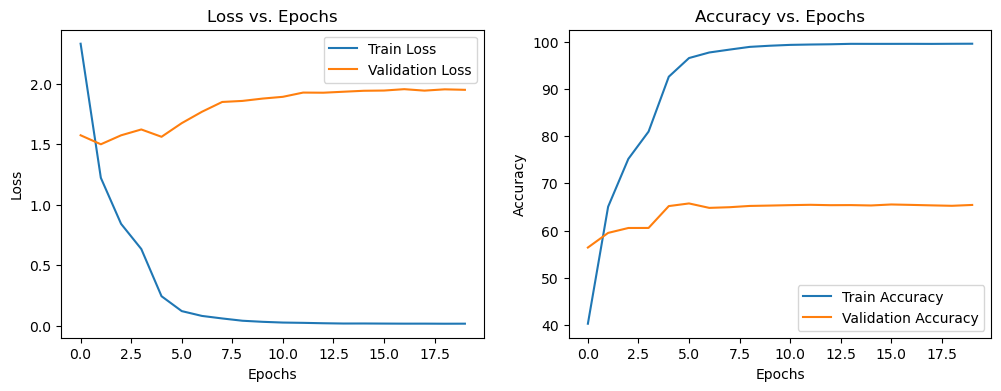

In [25]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

plt.show()

In [26]:
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Final Test Accuracy: 65.74%


## SI cross for ToGray

In [12]:
import albumentations as A
import cv2
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# Declare an augmentation pipeline
image_transform = A.Compose([
     A.ToGray()
])

# Define data transformations including the Albumentations transform
transform1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Lambda(lambda img: image_transform(image=np.array(img))["image"]),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset without Albumentations transform
cifar100_original = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar100_train_augmented = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform1)
cifar100_test_augmented = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform2)

# Combine original and augmented datasets
cifar100_train_combined = torch.utils.data.ConcatDataset([cifar100_original, cifar100_train_augmented])
cifar100_test_combined = torch.utils.data.ConcatDataset([cifar100_test_augmented])

# Define the size of the balanced subset for both train and test sets
subset_fraction_train = 0.2
subset_fraction_test = 0.2

# Calculate the number of samples needed for the balanced subset for both train and test sets
subset_size_train = int(subset_fraction_train * len(cifar100_train_combined))
subset_size_test = int(subset_fraction_test * len(cifar100_test_combined))

# Create a balanced subset for both train and test sets using SubsetRandomSampler
class_indices_train = list(range(len(cifar100_train_augmented.classes)))
class_indices_test = list(range(len(cifar100_test_augmented.classes)))

class_subset_size_train = int(subset_size_train / len(cifar100_train_augmented.classes))
class_subset_size_test = int(subset_size_test / len(cifar100_test_augmented.classes))

class_sampler_indices_train = []
class_sampler_indices_test = []

for class_index in class_indices_train:
    class_indices_list_train = [i for i, label in enumerate(cifar100_train_augmented.targets) if label == class_index]
    class_sampler_indices_train.extend(class_indices_list_train[:class_subset_size_train])

for class_index in class_indices_test:
    class_indices_list_test = [i for i, label in enumerate(cifar100_test_augmented.targets) if label == class_index]
    class_sampler_indices_test.extend(class_indices_list_test[:class_subset_size_test])

train_sampler = SubsetRandomSampler(class_sampler_indices_train)
test_sampler = SubsetRandomSampler(class_sampler_indices_test)

# Create PyTorch data loaders using the balanced subset for both train and test sets
batch_size = 256
train_loader = torch.utils.data.DataLoader(cifar100_train_combined, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(cifar100_test_combined, batch_size=batch_size, sampler=test_sampler)

# Check the number of samples in each set
print(f"Balanced Train set size: {len(train_loader.sampler)}")
print(f"Balanced Test set size: {len(test_loader.sampler)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Balanced Train set size: 20000
Balanced Test set size: 2000


In [13]:
# Extract data and labels from loaders
cifar100_train_data, cifar100_train_labels = [], []
for data, label in train_loader:
    cifar100_train_data.append(data)
    cifar100_train_labels.append(label)

cifar100_test_data, cifar100_test_labels = [], []
for data, label in test_loader:
    cifar100_test_data.append(data)
    cifar100_test_labels.append(label)

# Concatenate the lists of tensors
cifar100_train_data = torch.cat(cifar100_train_data, dim=0)
cifar100_train_labels = torch.cat(cifar100_train_labels, dim=0)
cifar100_test_data = torch.cat(cifar100_test_data, dim=0)
cifar100_test_labels = torch.cat(cifar100_test_labels, dim=0)

# Convert to desired format
train_data_tensor = cifar100_train_data
train_data_tensor = train_data_tensor.view(train_data_tensor.size(0), -1)

train_label_tensor = cifar100_train_labels.unsqueeze(1)

test_data_tensor = cifar100_test_data
test_data_tensor = test_data_tensor.view(test_data_tensor.size(0), -1)

test_label_tensor = cifar100_test_labels.unsqueeze(1)

In [14]:
train_si_calculator = Kalhor_SeparationIndex(train_data_tensor, train_label_tensor, normalize=True)
test_si_calculator = Kalhor_SeparationIndex(test_data_tensor, test_label_tensor, normalize=True)

data becomes normalized
data becomes normalized


In [15]:
# Calculate cross_si_data for the test dataset
cross_si_data = train_si_calculator.cross_si_data(test_data_tensor, test_label_tensor)
num_ones = torch.sum(cross_si_data == True).item()
total_elements = cross_si_data.numel()
ratio_ones = num_ones / total_elements

print("Cross SI:", ratio_ones)

Cross SI: 0.144
